# Model-Free TD Control: Q-Learning and SARSA

---

## 相关算法：

- Q-Learning

- SARSA

## 作业类型：

- 代码补全(共4处，以TODO标出了)

- 简答题(下一个cell里)



## 环境：Cliff Walking

这是一个标准的有起始状态、有目标状态的确定性转移环境。可选的动作是上下左右移动。奖励(Reward)在除了走到悬崖区域里的动作是-100以外均为-1。由于算的是累计奖励，所以你的智能体应该学会在不掉到悬崖的情况下尽快到达终点。

## 算法：

在这个作业里面，我们使用$\epsilon$-greedy算法进行exploration：
- 以$\epsilon$概率随机选择一个action。
- 以$1 - \epsilon$概率选择当前认为的最优状态。

## 参考资料：


- [Sutton's Reinforcement Book](http://incompleteideas.net/book/bookdraft2017nov5.pdf)
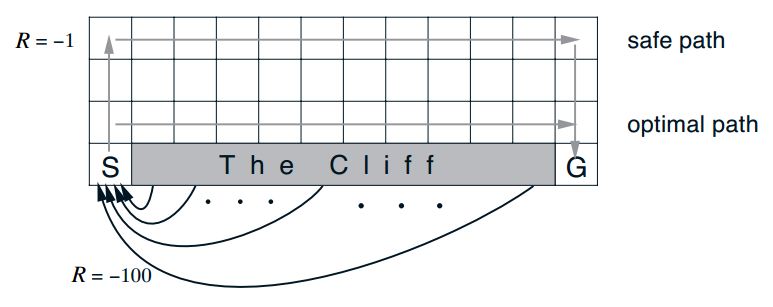

# 简答题：

请简要谈谈你对于以下强化学习相关术语（组）的理解：

- Exploration & Exploitation

Exploitation 指的是在学习的过程中为了获得更好的reward而去选择已知的有较好reward的走法
Exploration 指的是在学习的过程中为了以后能够拿到更好的reward而去走未知的未走过的走法

- State & History

History 指的是学习过程中已经获取了的全部的数据
State 指的是对已有的history的一个总结（summary），是对history的表征并且会被用以对未来进行预测

- Model free reinforcement learning

指的是只依赖现有的环境和样例，不会试图找到状态特点，通过不断试错进行调整的增强学习的方法。其不会使用已经获得的预测和概率来调整选择，其结果也不会给出一个特定的模型对未来的概率进行预测。具体的比如有Monte Carlo Control, SARSA, Q-learning等方法都属于model free reinforcement learning.

In [6]:
import time
import random

# 环境定义

In [7]:
class Env():
    def __init__(self, length, height):
        # define the height and length of the map
        self.length = length
        self.height = height
        # define the agent's start position
        self.x = 0
        self.y = 0

    def render(self, frames=50):
        for i in range(self.height):
            if i == 0: # cliff is in the line 0
                line = ['S'] + ['x']*(self.length - 2) + ['T'] # 'S':start, 'T':terminal, 'x':the cliff
            else:
                line = ['.'] * self.length
            if self.x == i:
                line[self.y] = 'o' # mark the agent's position as 'o'
            print(''.join(line))
        print('\033['+str(self.height+1)+'A')  # printer go back to top-left 
        time.sleep(1.0 / frames)

    def step(self, action):
        """4 legal actions, 0:up, 1:down, 2:left, 3:right"""
        change = [[0, 1], [0, -1], [-1, 0], [1, 0]]
        self.x = min(self.height - 1, max(0, self.x + change[action][0]))
        self.y = min(self.length - 1, max(0, self.y + change[action][1]))

        states = [self.x, self.y]
        reward = -1
        terminal = False
        if self.x == 0: # if agent is on the cliff line "SxxxxxT"
            if self.y > 0: # if agent is not on the start position 
                terminal = True
                if self.y != self.length - 1: # if agent falls
                    reward = -100
        return reward, states, terminal

    def reset(self):
        self.x = 0
        self.y = 0

## Q-Learning 


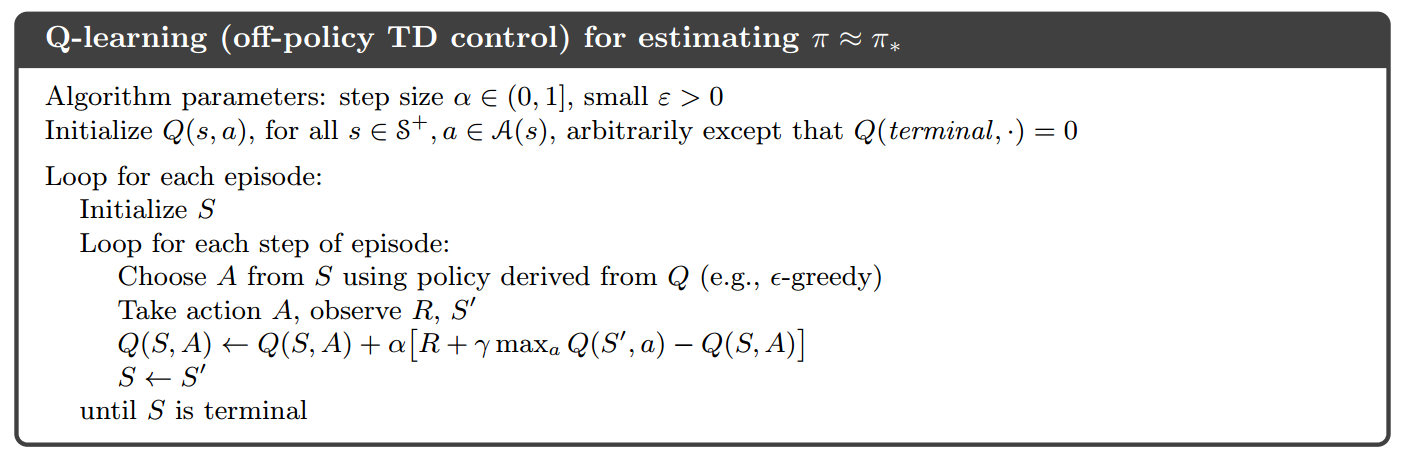

In [8]:
import numpy as np
class Q_table():
    def __init__(self, length, height, actions=4, alpha=0.1, gamma=0.9):
        self.table = [0] * actions * length * height # initialize all Q(s,a) to zero
        self.actions = actions
        self.length = length
        self.height = height
        self.alpha = alpha
        self.gamma = gamma

    def _index(self, a, x, y):
        """Return the index of Q([x,y], a) in Q_table."""
        return a * self.height * self.length + x * self.length + y

    def _epsilon(self, num_episode):
        # return 0.1
        # version for better convergence:
        # """At the beginning epsilon is 0.2, after 300 episodes decades to 0.05, and eventually go to 0."""
        return 20. / (num_episode + 100)

    # TODO: finish the next 3 functions

    def take_action(self, x, y, num_episode):
        """epsilon-greedy action selection"""
        if random.random() < self._epsilon(num_episode):
            action = np.random.choice(self.actions)
            # return a random action
            # pass
        else:
            mx_nxt_reward = -999999
            for a in range(self.actions):
                nxt_reward = self.table[self._index(a, x, y)]
                if nxt_reward >= mx_nxt_reward:
                    action = a
                    mx_nxt_reward = nxt_reward
        return action
            # return a greedy action
            # pass

    def max_q(self, x, y):
        max_q_ = -999999
        for a in range(self.actions):
            max_q_ = max(max_q_, self.table[self._index(a, x, y)])
        return max_q_
        # return the optimal Q value
        # pass

    def update(self, a, s0, s1, r, is_terminated):
        # both s0, s1 have the form [x,y]
        # do the update
        # hint: model should be update differently while s1 is the terminal state
        if is_terminated:
            for action in range(self.actions):
                self.table[self._index(action, s1[0], s1[1])] = r
        max_q_ = self.max_q(s1[0], s1[1])
        td_target = r + self.gamma * max_q_
        td_delta = td_target - self.table[self._index(a, s0[0], s0[1])]
        self.table[self._index(a, s0[0], s0[1])] += (self.alpha * td_delta)
        # pass

## 测试

In [9]:
def cliff_walk():
    env = Env(length=12, height=4)
    table = Q_table(length=12, height=4)
    for num_episode in range(3000):
        episodic_reward = 0
        is_terminated = False
        s0 = [0, 0]
        while not is_terminated:
            action = table.take_action(s0[0], s0[1], num_episode)
            reward, s1, is_terminated = env.step(action)
            
            table.update(a=action, s0=s0, s1=s1, r=reward, is_terminated=is_terminated)
            
            episodic_reward += reward
            s0 = s1
            # TODO: 根据当前状态，用你的模型给出action，提供给环境，
            # 将当前得到的反馈对你的模型进行更新，并将episodic_reward加上这一时刻的reward
            # is_terminated = True
            # pass
            
        
        if num_episode % 20 == 0:
            print("Episode: {}, Score: {}".format(num_episode, episodic_reward))
        env.reset()

In [10]:
cliff_walk()

Episode: 0, Score: -109
Episode: 20, Score: -32
Episode: 40, Score: -185
Episode: 60, Score: -119
Episode: 80, Score: -134
Episode: 100, Score: -45
Episode: 120, Score: -56
Episode: 140, Score: -43
Episode: 160, Score: -34
Episode: 180, Score: -36
Episode: 200, Score: -31
Episode: 220, Score: -32
Episode: 240, Score: -33
Episode: 260, Score: -100
Episode: 280, Score: -13
Episode: 300, Score: -28
Episode: 320, Score: -104
Episode: 340, Score: -26
Episode: 360, Score: -13
Episode: 380, Score: -32
Episode: 400, Score: -17
Episode: 420, Score: -13
Episode: 440, Score: -110
Episode: 460, Score: -15
Episode: 480, Score: -13
Episode: 500, Score: -13
Episode: 520, Score: -13
Episode: 540, Score: -13
Episode: 560, Score: -13
Episode: 580, Score: -13
Episode: 600, Score: -13
Episode: 620, Score: -13
Episode: 640, Score: -15
Episode: 660, Score: -102
Episode: 680, Score: -13
Episode: 700, Score: -15
Episode: 720, Score: -13
Episode: 740, Score: -13
Episode: 760, Score: -13
Episode: 780, Score: -1

## SARSA
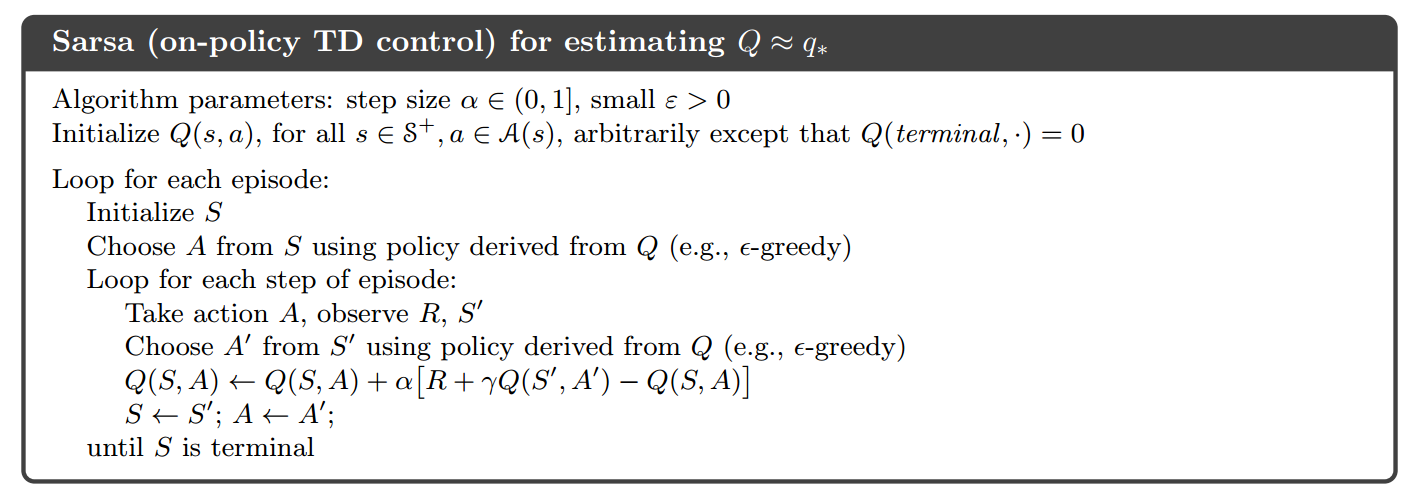

In [13]:
class Q_table_sarsa():
    def __init__(self, length, height, actions=4, alpha=0.1, gamma=0.9):
        self.table = [0] * actions * length * height # initialize all Q(s,a) to zero
        self.actions = actions
        self.length = length
        self.height = height
        self.alpha = alpha
        self.gamma = gamma

    def _index(self, a, x, y):
        """Return the index of Q([x,y], a) in Q_table."""
        return a * self.height * self.length + x * self.length + y

    def _epsilon(self, num_episode):
        # return 0.1
        # version for better convergence:
        # """At the beginning epsilon is 0.2, after 300 episodes decades to 0.05, and eventually go to 0."""
        return 20. / (num_episode + 100)

    # TODO: finish the next 3 functions

    def take_action(self, x, y, num_episode):
        """epsilon-greedy action selection"""
        if random.random() < self._epsilon(num_episode):
            action = np.random.choice(self.actions)
            # return a random action
            # pass
        else:
            mx_nxt_reward = -999999
            for a in range(self.actions):
                nxt_reward = self.table[self._index(a, x, y)]
                if nxt_reward >= mx_nxt_reward:
                    action = a
                    mx_nxt_reward = nxt_reward
        return action
            # return a greedy action
            # pass

    def max_q(self, x, y):
        pass
        # return the optimal Q value
        # pass

    def update(self, a, a_, s0, s1, r, is_terminated):
        # both s0, s1 have the form [x,y]
        # do the update
        # hint: model should be update differently while s1 is the terminal state
        if is_terminated:
            for action in range(self.actions):
                self.table[self._index(action, s1[0], s1[1])] = r
        td_target = r + self.gamma * self.table[self._index(a_, s1[0], s1[1])]
        td_delta = td_target - self.table[self._index(a, s0[0], s0[1])]
        self.table[self._index(a, s0[0], s0[1])] += (self.alpha * td_delta)
        # pass

In [14]:
def cliff_walk_sarsa():
    env = Env(length=12, height=4)
    table = Q_table_sarsa(length=12, height=4)
    for num_episode in range(3000):
        # within the whole learning process
        episodic_reward = 0
        is_terminated = False
        s0 = [0, 0]
        action = table.take_action(s0[0], s0[1], num_episode)
        while not is_terminated:
            reward, s1, is_terminated = env.step(action)
            action_ = table.take_action(s1[0], s1[1], num_episode)
            
            table.update(a=action, a_=action_, s0=s0, s1=s1, r=reward, is_terminated=is_terminated)
            
            episodic_reward += reward
            s0 = s1
            action = action_
            # TODO: 根据当前状态，用你的模型给出action，提供给环境，
            # 将当前得到的反馈对你的模型进行更新，并将episodic_reward加上这一时刻的reward
            # is_terminated = True
            # pass
            
        if num_episode % 20 == 0:
            print("Episode: {}, Score: {}".format(num_episode, episodic_reward))
        env.reset()

In [15]:
cliff_walk_sarsa()

Episode: 0, Score: -128
Episode: 20, Score: -234
Episode: 40, Score: -119
Episode: 60, Score: -68
Episode: 80, Score: -57
Episode: 100, Score: -49
Episode: 120, Score: -29
Episode: 140, Score: -47
Episode: 160, Score: -31
Episode: 180, Score: -35
Episode: 200, Score: -15
Episode: 220, Score: -29
Episode: 240, Score: -27
Episode: 260, Score: -33
Episode: 280, Score: -17
Episode: 300, Score: -15
Episode: 320, Score: -19
Episode: 340, Score: -19
Episode: 360, Score: -19
Episode: 380, Score: -19
Episode: 400, Score: -21
Episode: 420, Score: -21
Episode: 440, Score: -19
Episode: 460, Score: -19
Episode: 480, Score: -21
Episode: 500, Score: -21
Episode: 520, Score: -17
Episode: 540, Score: -17
Episode: 560, Score: -17
Episode: 580, Score: -17
Episode: 600, Score: -21
Episode: 620, Score: -17
Episode: 640, Score: -17
Episode: 660, Score: -21
Episode: 680, Score: -17
Episode: 700, Score: -17
Episode: 720, Score: -17
Episode: 740, Score: -17
Episode: 760, Score: -17
Episode: 780, Score: -17
Epi